In [1]:
import numpy as np
import torch
from tqdm import tqdm
import json
import os
import matplotlib.pyplot as plt


### Raw garage pos process

In [4]:
f = open('garage_pos_raw.json', 'r')
p = json.load(f)['car_park']
f.close()

res = {}

for g in p:
    id = g['park_id']
    res[id] = g

f = open('garage_pos.json', 'w')
f.write(json.dumps(res))
f.close()

### Peek

In [5]:
path = 'garage'
dates = os.listdir(path)
for date in dates[:1]:
    times = os.listdir(os.path.join(path, date))
    for file in times[:1]:
        f = open(os.path.join(path, date, file), 'r')
        p = json.loads(f.read())['car_park']
        f.close()

In [6]:
len(p)

340

In [7]:
i = 233
print(p[i])
print(res[p[i]['park_id']])

{'park_id': 'tdc32p4', 'vehicle_type': [{'type': 'P', 'service_category': [{'category': 'HOURLY', 'vacancy_type': 'A', 'vacancy': 35, 'lastupdate': '2021-06-26 08:42:36'}]}, {'type': 'L', 'service_category': [{'category': 'HOURLY', 'vacancy_type': 'A', 'vacancy': 0, 'lastupdate': '2021-06-26 08:42:36'}]}, {'type': 'H', 'service_category': [{'category': 'HOURLY', 'vacancy_type': 'A', 'vacancy': 0, 'lastupdate': '2021-06-26 08:42:36'}]}, {'type': 'M', 'service_category': [{'category': 'HOURLY', 'vacancy_type': 'A', 'vacancy': 0, 'lastupdate': '2021-06-26 08:42:36'}]}]}
{'park_id': 'tdc32p4', 'name_en': 'Pok Hong Estate', 'name_tc': '博康邨', 'name_sc': '博康邨', 'displayAddress_en': 'Sha Kok Street, Shatin, New Territories', 'displayAddress_tc': '新界沙田沙角街', 'displayAddress_sc': '新界沙田沙角街', 'latitude': 22.37539675, 'longitude': 114.19316679, 'district_en': 'Sha Tin', 'district_tc': '沙田區', 'district_sc': '沙田区', 'contactNo': '2512 9611', 'opening_status': 'OPEN', 'height': 1.9, 'remark_en': 'Height

In [8]:
type_dict = {}
for g in p:
    for t in g['vehicle_type']:
        key = t['type']
        vac = t['service_category'][0]['vacancy']
        if key in type_dict:
            type_dict[key][0] += 1
            type_dict[key][1] += vac
        else:
            type_dict[key] = [1, vac]


for t in type_dict.keys():
    stat = type_dict[t]
    print(t, stat[0], stat[1] / stat[0])

P 327 32.4434250764526
M 32 5.15625
T 8 4.875
L 18 10.777777777777779
B 15 4.866666666666666
O 2 1.0
H 5 14.6
N 6 5.5
C 5 10.2


### select usable ids

In [9]:
usable_ids = set(res.keys())

path = 'garage'
dates = os.listdir(path)
for date in tqdm(dates[:]):
    times = os.listdir(os.path.join(path, date))
    usable_ids_this_file = set()
    for file in times[:]:
        f = open(os.path.join(path, date, file), 'r')
        try:
            p = json.loads(f.read())['car_park']
        except:
            print(os.path.join(path, date, file))
        f.close()
        
        for g in p:
            for t in g['vehicle_type']:
                if t['type'] == 'P':
                    usable_ids_this_file.add(g['park_id'])
                    break
    
    # appears in every file
    usable_ids &= usable_ids_this_file

print(len(usable_ids))

100%|██████████| 84/84 [02:04<00:00,  1.48s/it]

298


In [10]:
path = 'garage'
dates = os.listdir(path)

usable_ids_dict = {}
count = 0
for id in usable_ids:
    usable_ids_dict[id] = [0, 1e6, 0]

for date in tqdm(dates[:]):
    times = os.listdir(os.path.join(path, date))
    usable_ids_this_file = set()
    for file in times[:]:
        f = open(os.path.join(path, date, file), 'r')
        try:
            p = json.loads(f.read())['car_park']
        except:
            print(os.path.join(path, date, file))
            f.close()
            continue
        f.close()
        count += 1
        for g in p:
            id = g['park_id']
            if id in usable_ids:
                for t in g['vehicle_type']:
                    if t['type'] == 'P':
                        v = t['service_category'][0]['vacancy']
                        usable_ids_dict[id][0] += v
                        usable_ids_dict[id][1] = min(v, usable_ids_dict[id][1])
                        usable_ids_dict[id][2] = max(v, usable_ids_dict[id][2])
                        


100%|██████████| 84/84 [00:31<00:00,  2.63it/s]


In [11]:
threshold = 1.01
avg_list = []
final_id_list = []
for id in usable_ids:
    avg = usable_ids_dict[id][0] / count
    avg_list.append(avg)
    print('%.2f\t'%(avg), end='')
    if avg > threshold and usable_ids_dict[id][1] != usable_ids_dict[id][2]:
        final_id_list.append(id)

0.96	2.75	1.00	0.61	70.52	1.00	0.97	2.95	11.47	0.95	0.58	0.00	0.87	1.00	1.44	3.70	10.50	1.00	28.48	22.47	0.99	139.09	169.63	1.00	352.17	16.42	0.98	59.32	0.99	0.72	0.98	0.85	0.99	1.00	1.09	1.60	1.00	21.26	0.97	1.00	1.00	44.13	44.40	128.68	0.00	80.95	1.45	134.14	0.99	1.59	94.46	0.66	4.58	37.63	5.70	54.48	1.00	75.84	1.00	67.64	0.56	17.46	0.93	11.60	0.86	2.08	23.47	0.77	1.00	53.61	0.99	0.82	14.27	0.99	14.33	1.07	0.73	0.96	0.91	14.57	27.30	9.70	0.00	1.00	0.95	49.99	25.59	86.60	13.68	1.00	1.00	0.97	10.05	1.00	80.16	0.99	1.00	4.63	0.99	342.04	86.24	1.00	0.99	0.00	1.00	89.29	1.00	0.21	28.26	1.00	1.00	28.86	0.94	60.60	5.00	0.98	100.00	0.85	0.98	1.00	0.88	0.89	1.00	0.82	0.96	14.02	130.15	1.00	1.00	39.99	22.03	0.63	94.13	35.00	1.00	0.99	0.99	6.83	1.00	0.99	0.88	0.65	1.00	1.00	1.00	36.51	1.00	12.89	0.99	1.00	23.37	1.00	1.00	32.53	211.13	9.74	0.91	20.12	0.92	21.32	0.89	0.97	1.00	0.98	0.00	0.97	13.82	0.11	1.00	1.00	29.75	0.91	42.72	1.00	60.51	22.64	0.20	0.99	0.88	113.21	1.00	82.80	0.73	14.28	0.99	0.

In [12]:
print(len(usable_ids), len(final_id_list))

298 116


### index file

In [13]:
id_list = sorted(final_id_list)
id_dict = {}

f = open('garage_index.csv', 'w')
for i, id in enumerate(id_list):
    lat = res[id]['latitude']
    lon = res[id]['longitude']
    f.write(','.join([str(i), id, str(lat), str(lon)]) + '\n')
    id_dict[id] = [i, lat, lon]
f.close()
    

### dataset

In [16]:
path = 'garage'
dates = os.listdir(path)
size = len(id_dict)
file_idx = 0
save_path = 'garage_dataset'

data_avg = torch.zeros(size)

for date in tqdm(dates[:]):
    times = os.listdir(os.path.join(path, date))
    if len(times) != 288:
        print(date)
    for file in times[:]:
        f = open(os.path.join(path, date, file), 'r')
        try:
            p = json.loads(f.read())['car_park']
        except:
            print(os.path.join(path, date, file))
            f.close()
            continue
        f.close()
        
        data = torch.zeros(size, dtype=int)
        
        for g in p:
            if g['park_id'] in id_dict:
                for t in g['vehicle_type']:
                    if t['type'] == 'P':
                        data_idx = id_dict[g['park_id']][0]
                        data[data_idx] = t['service_category'][0]['vacancy']
        
        data_avg += data
        data = torch.maximum(data, torch.zeros_like(data))
        torch.save(data, os.path.join(save_path, '%d.pt'%file_idx))
        file_idx += 1
        
data_avg /= file_idx


100%|██████████| 84/84 [00:44<00:00,  1.88it/s]


In [17]:
for i, n in enumerate(data_avg):
    print('%i:%.2f\t'%(i, n), end='')
min(data_avg)

0:27.30	1:42.72	2:23.47	3:80.95	4:60.60	5:128.68	6:30.41	7:80.16	8:305.95	9:3.70	10:2.08	11:10.49	12:59.32	13:9.74	14:7.00	15:14.10	16:13.33	17:9.70	18:130.15	19:8.38	20:6.05	21:211.13	22:1.07	23:1.09	24:4.58	25:25.59	26:36.51	27:1.59	28:1.60	29:342.04	30:134.14	31:22.64	32:20.12	33:32.53	34:2.75	35:22.03	36:39.99	37:28.26	38:14.18	39:13.26	40:14.33	41:18.51	42:4.67	43:10.16	44:67.86	45:49.38	46:22.47	47:10.50	48:20.18	49:53.08	50:75.84	51:28.48	52:13.82	53:1.44	54:4.27	55:11.60	56:12.89	57:7.63	58:6.83	59:4.63	60:8.47	61:18.07	62:13.68	63:1.45	64:2.95	65:49.99	66:476.37	67:44.40	68:44.47	69:16.42	70:327.18	71:206.96	72:113.21	73:150.47	74:130.66	75:67.18	76:54.48	77:60.51	78:24.69	79:94.13	80:43.93	81:352.17	82:70.52	83:89.29	84:94.46	85:34.55	86:169.63	87:53.87	88:139.09	89:91.38	90:14.57	91:17.29	92:9.96	93:5.70	94:82.80	95:86.24	96:23.37	97:122.25	98:67.64	99:53.61	100:11.47	101:14.28	102:14.27	103:43.22	104:44.13	105:86.60	106:28.86	107:37.63	108:17.30	109:29.75	110:21.26	111:14.0

tensor(1.0731)

100%|██████████| 1000/1000 [00:00<00:00, 3759.40it/s]


Text(0, 0.5, 'vacancy')

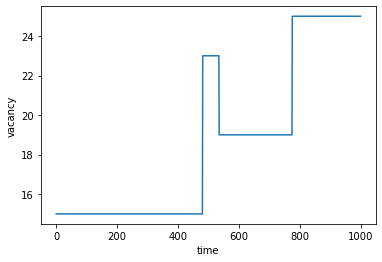

In [4]:
# idx = 12
# idx = 13
# idx = 17
idx = 100
path = 'garage_dataset'
m, n = 0, 1000
x = []
curve = []
size = len(os.listdir(path)) - 1
for i in tqdm(range(m, n)):
    i %= size
    x.append(i)
    data = torch.load(os.path.join(path, '%d.pt'%i))
    curve.append(data[idx])
    
plt.plot(x, curve)
plt.xlabel('time')
plt.ylabel('vacancy')

### Link Graph

In [19]:
f = open('garage_index.csv', 'r')
lines = f.read().splitlines()
f.close()

park_list = []

for line in lines:
    index, park, lat, lon = line.split(',')
    park_list.append((int(index), float(lat), float(lon)))
    
link_graph = np.eye(len(park_list), dtype=bool)
link_graph.shape

threshold = 0.01

for park in tqdm(park_list):
    i, lat, lon = park

    for neighbor in park_list[i:]:
        j, j_lat, j_lon = neighbor
        if ((lat - j_lat)**2 + (lon - j_lon)**2)**0.5 < threshold:
            link_graph[i, j] = True
            link_graph[j, i] = True
            

res = [[], []]

m, n = link_graph.shape

for i in tqdm(range(m)):
    for j in range(n):
        if link_graph[i, j] and i != j:
            res[0].append(i)
            res[1].append(j)
            
edge_graph = torch.tensor(res)

torch.save(edge_graph, 'garage_dataset/link.pt')

100%|██████████| 116/116 [00:00<00:00, 58011.12it/s]


100%|██████████| 116/116 [00:00<00:00, 10891.37it/s]


(22.194, 22.554)

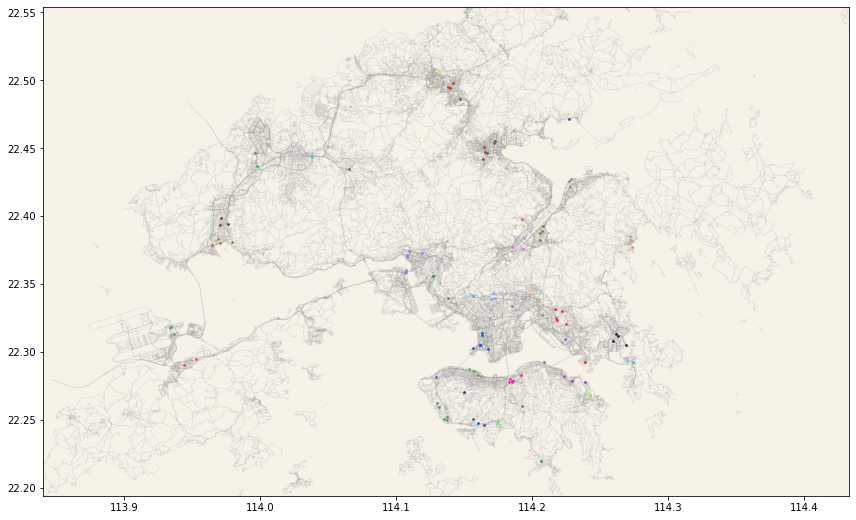

In [20]:
import random


visited = [0] * len(park_list)
group_list = []

def dfs(i, local):
    # print(len(local))
    local.append(i)
    for j, v in enumerate(link_graph[i]):
        if v == True and j != i and visited[j] == 0:
            visited[j] = 1
            dfs(j, local)

for i in tqdm(range(len(link_graph))[:]):
    if visited[i] == 0:
        local = []
        visited[i] = 1
        dfs(i, local)
        group_list.append(local)


plt.figure(figsize=(15, 9))
bg = plt.imread('hk.png')
plt.imshow(bg, extent=[113.84, 114.433, 22.194, 22.554])

for group in group_list:
    r = random.randint(16, 255)
    g = random.randint(16, 255)
    b = random.randint(16, 255)
    color = '#%x%x%x'%(r, g, b)
    
    lats = []
    lons = []
    
    for i in group:
        lat, lon = park_list[i][-2:]
        lats.append(lat)
        lons.append(lon)
        
    plt.scatter(lons, lats, c=color, s=3, linewidths=None, alpha=0.9)

plt.xlim(113.84, 114.433)
plt.ylim(22.194, 22.554)

In [ ]:
torch.load('garage_dataset/0.pt')

tensor([ 63,  49,  16, 127,  98, 215,  50, 131, 338,   0,   0,  16,  95,  11,
          7,  15,  18,  13, 158,   9,   0, 227,   1,   1,   4,  25,  35,  35,
          5,   0,   2, 333, 148,  33,  25,  37,   0,  25,  34,  31,  15,  21,
         14,  19,   5,  10,  92,  78,  33,  13,  25,  67,  79,  37,  13,   1,
         11,  11,  20,  18,  17,   4,   9,  42,   5,   0,   0,  57, 763,  54,
         55,  16, 537, 282, 167, 232, 202, 100,  72,  99,  29, 145,  68, 486,
        132, 131, 137,  69, 285,  85, 150,  68,  12,  21,   0, 100,   3,  89,
         91,  17,   5, 110,  18,  80,  15,  17,  14,  56,  38,  75,  30,  30,
         15,  30,  30,  32,  13,  24,   7,  68,  46])